In [63]:
import numpy as np
import operator
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [64]:
def create_dataset(datapath):
    #读取dat文件作为聚类数据的数据集
    data = np.loadtxt(datapath)
    X = data[:, 0:]
    #转化X为np.array
    X = np.array(X)
    return X

datapath = './data/clusterData4.8k.dat'
X_train = create_dataset(datapath)
print(X_train.shape)

(8000, 2)


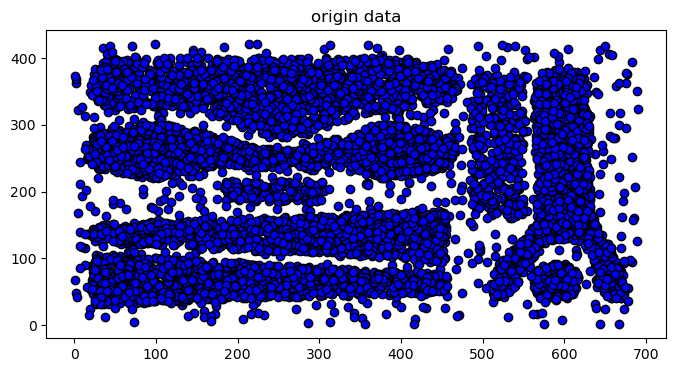

In [111]:
#可视化数据集
def visualize_data(X):

    plt.figure(figsize=(8,4))
    plt.title('origin data')
    plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', label='datapoints',edgecolors='black')
    plt.show()

visualize_data(X_train)
data = np.loadtxt("data/cluster.csv", delimiter=",")

In [112]:
def visualize(X, y, y_pred, title=None, type='pca'):
    # 可视化,pca降维或者tsne
    if type == 'pca':
        pca = PCA(n_components=2)
        X_dim_reduction = pca.fit_transform(X)

    elif type == 'tsne':
        t_sne = TSNE(n_components=2)
        X_dim_reduction = t_sne.fit_transform(X)
    else:
        X_dim_reduction = X
    # print(X_dim_reduction.shape)
    plt.figure(figsize=(16, 6))

    def get_color(y):
        color_dict = {-1: 'white', 0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'magenta', 
                      5: 'blue', 6: 'cyan', 7: 'brown', 8: 'purple', 9: 'aquamarine'}
        color = []
        for i in range(y.shape[0]):
            color.append(color_dict.get(y[i].item(), 'olive'))
        return color
    plt.suptitle(title, fontweight=16)
    plt.subplot(121)
    plt.title('origin data')
    #使用降维后的两个维度进行绘图
    plt.scatter(X_dim_reduction[:, 0], X_dim_reduction[:, 1], c=get_color(y), edgecolors='black')
    plt.subplot(122)
    plt.title('cluster result')
    plt.scatter(X_dim_reduction[:, 0], X_dim_reduction[:, 1], c=get_color(y_pred), edgecolors='black')
    plt.show()

In [105]:
class OPTICS:
    def __init__(self,eps=np.inf,minPts=15):
        self.data = None
        self.eps = eps
        self.minPts = minPts
        self.seeds = {}
        self.isProcess = None
        self.disMat = None
        self.reach_dists = None
        self.core_dists = None
    # 计算距离矩阵
    def distM(self):
        return squareform(pdist(self.data,metric='euclidean'))
    
    def updateSeeds(self,core_PointId,neighbours):
        disMat = self.disMat
        isProcess = self.isProcess
        core_dists = self.core_dists

        # 获得核心点core_PointId的核心距离
        core_dist=core_dists[core_PointId]
        # 遍历core_PointId 的每一个邻居点
        for neighbour in neighbours:
            # 如果neighbour没有被处理过，计算该核心距离
            if(isProcess[neighbour]==-1):
                # 首先计算该点针对core_PointId的可达距离
                new_reach_dist = max(core_dist, disMat[core_PointId][neighbour])
                # 如果该点的可达距离未定义，即为未访问过，将其放入seeds中
                if(np.isnan(self.reach_dists[neighbour])):
                    self.reach_dists[neighbour]=new_reach_dist
                    self.seeds[neighbour] = new_reach_dist
                # 如果该点的可达距离已经定义，比较新计算的可达距离和原有的可达距离，将小的放入seeds
                elif(new_reach_dist<self.reach_dists[neighbour]):
                    self.reach_dists[neighbour] = new_reach_dist
                    self.seeds[neighbour] = new_reach_dist
        return self.seeds
    
    #计算数据集中的可达列表，及其可达距离
    def compute_optics(self):
        eps = self.eps
        minPts = self.minPts
        data = self.data
        # 获得距离矩阵
        self.disMat = self.distM()
        disMat = self.disMat
        #print(f'disMat.shape:{disMat.shape}')
        orders = []
        # 获得数据的行和列(一共有n条数据)
        n, m = data.shape
        # 初始化可达距离，处理标记
        self.reach_dists= np.full((n,), np.nan)
        self.isProcess = np.full((n,), -1)

        # 找到每个点距离矩阵中距离从小到大排序后第minPTS个元素的索引，然后按照索引计算每个点到第minPTS个元素的距离，为核心距离
        minPts_index = np.argsort(disMat)[:,minPts-1]
        temp_core_distances = disMat[np.arange(0,n),minPts_index]
        # 核心距离，小于eps的为核心点，大于eps的为非核心点
        self.core_dists = np.where(temp_core_distances <= eps, temp_core_distances, -1)
        
        
        # 将disMat矩阵的中小于eps的数赋予1，大于eps的数赋予零(list1)，对每一行求和,数量大于minPTs的就是核心点
        list1 = np.where(disMat <= eps, 1, 0)
        core_points_index = np.where(np.sum(list1, axis=1) >= minPts)[0]

        print(f'core_points_index:{core_points_index}')
        
        # 遍历所有的核心点
        for pointId in core_points_index:
            # 如果核心点未被分类，将其作为的种子点，开始寻找相应簇集
            if (self.isProcess[pointId] == -1):
                # 将点pointId标记为当前类别(即标识为已操作)
                self.isProcess[pointId] = 1
                orders.append(pointId)
                # 寻找种子点的eps邻域且没有被分类的点，将其放入种子集合
                neighbours = np.where((disMat[:, pointId] <= eps)  & (self.isProcess == -1))[0]
                seeds = dict()
                # 用该核心点和它的领域更新种子点
                seeds= self.updateSeeds(pointId,neighbours)
                # 只要种子集合非空，就一直循环
                while len(seeds)>0:
                    # 从种子集合中取出第一个点
                    next_pointId = sorted(seeds.items(), key=operator.itemgetter(1))[0][0]
                    del seeds[next_pointId]
                    self.isProcess[next_pointId] = 1
                    orders.append(next_pointId)
                    # 寻找next_point 种子点eps邻域（包含自己）
                    next_neighbours = np.where(disMat[:, next_pointId] <= eps)[0]
                    if len(next_neighbours) >= minPts:
                        seeds=self.updateSeeds(next_pointId,next_neighbours)
                    # 簇集生长完毕，寻找到一个类别
        # 返回数据集中的可达列表，及其可达距离
        return orders,self.reach_dists
    
    def fit(self,data):
        self.data = data
        orders,reach_dists = self.compute_optics()
        print(f'len(orders):{len(orders)}')
        print(orders)
        print(f'len(reach_dists):{len(reach_dists)}')
        print(reach_dists)
        eps = 15
        # 获得数据的行和列
        n,m=data.shape
        # reach_dists[orders] 将每个点的可达距离，按照有序列表排序（即输出顺序）
        # np.where(reach_dists[orders] <= eps)[0]，找到有序列表中可达距离小于eps的点的索引，即对应有序列表的索引
        reach_distIds=np.where(reach_dists[orders] <= eps)[0]
        print(f'len(reach_distIds):{len(reach_distIds)}')
        print(reach_distIds)
        # current为当前点，pre为前一个点，clusterId为类别
        pre=reach_distIds[0]-1
        clusterId=0
        labels=np.full((n,),-1)
        for current in reach_distIds:
            # 如果current-pre!=1，说明是一个新的类别
            if(current-pre!=1):
                # 类别+1
                clusterId=clusterId+1
            labels[orders[current]]=clusterId
            pre=current
        return labels

In [106]:
myoptics = OPTICS(eps=np.inf,minPts=30)
labels = myoptics.fit(X_train)

core_points_index:[   0    1    2 ... 7997 7998 7999]
len(orders):8000
[0, 146, 1801, 1883, 1898, 2718, 2374, 1063, 1926, 2659, 2853, 2895, 3113, 3280, 3856, 3861, 4173, 4353, 4469, 4611, 4632, 4787, 4817, 5018, 5244, 5915, 5919, 6107, 6162, 6183, 6396, 6667, 7044, 7471, 7522, 7125, 3483, 5672, 6955, 7321, 7366, 730, 4275, 7602, 4578, 1997, 5083, 5237, 7800, 2537, 7806, 7155, 2053, 3687, 1835, 5095, 7805, 5210, 6556, 1718, 269, 804, 761, 2191, 943, 1812, 1880, 2369, 2958, 3252, 3295, 3582, 2380, 3662, 3753, 3869, 3961, 4046, 4300, 4954, 5245, 5505, 6078, 6111, 6352, 6645, 6757, 7110, 7424, 5513, 2320, 3586, 3904, 5298, 5363, 6192, 6623, 7067, 7418, 7648, 12, 275, 517, 39, 727, 860, 573, 1139, 1199, 1200, 1537, 1540, 1573, 2711, 3450, 3902, 587, 1291, 2041, 3215, 4049, 4131, 1643, 4236, 4540, 4759, 4780, 4929, 5123, 5721, 5865, 6105, 6230, 6379, 7444, 7849, 7934, 1158, 4145, 6103, 2066, 3506, 3693, 4177, 5964, 6440, 7740, 7917, 7053, 3375, 5507, 5971, 7218, 183, 563, 2780, 3423, 3951, 4

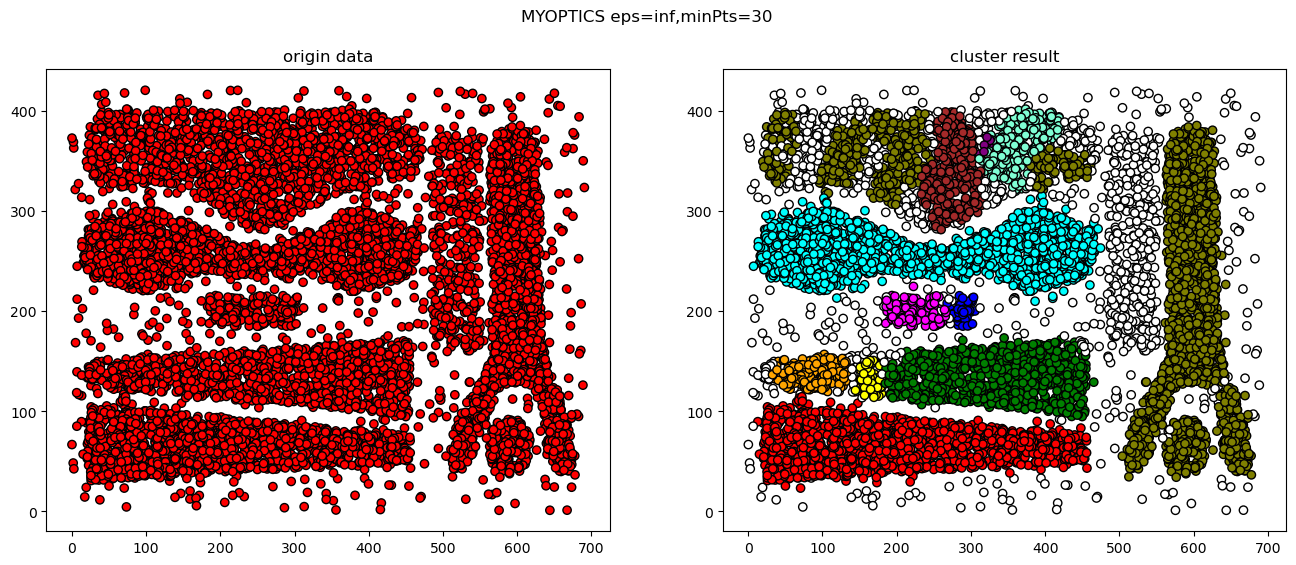

In [113]:
y = np.zeros(X_train.shape[0])
visualize(X_train, y, labels, title=f'MYOPTICS eps={np.inf},minPts={30}', type= None)

6


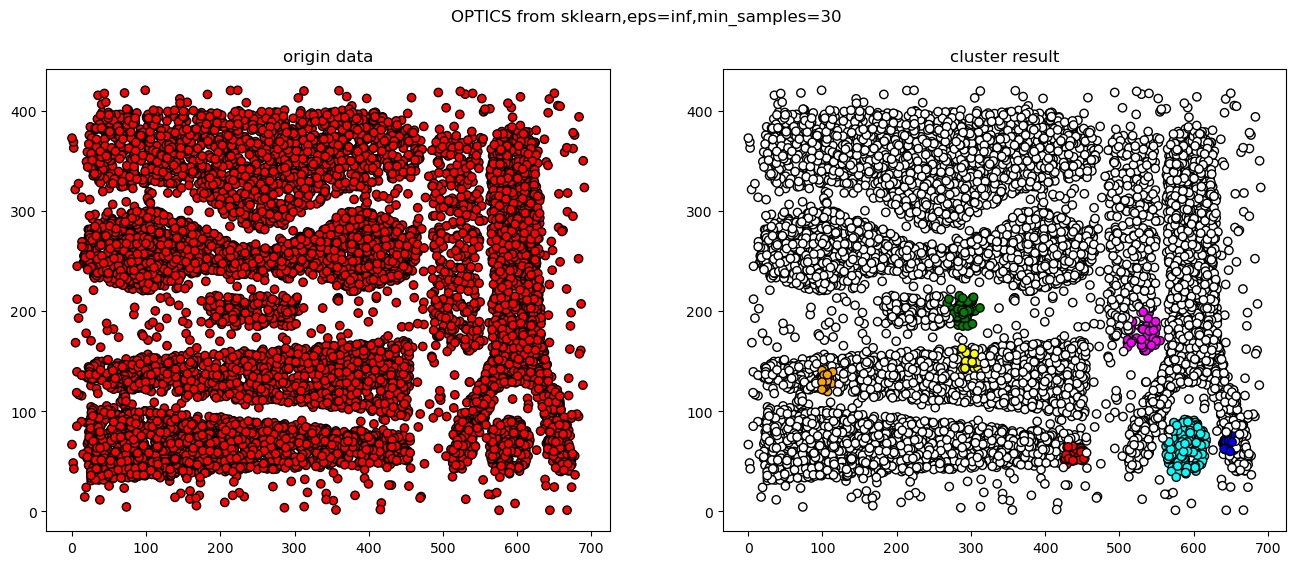

In [114]:
from sklearn.cluster import OPTICS
eps=np.inf
min_samples=30
optics = OPTICS(eps=eps, min_samples=min_samples)
y = np.zeros(X_train.shape[0])
y_pred = optics.fit_predict(X_train)
print(max(y_pred))
visualize(X_train, y, y_pred, title=f'OPTICS from sklearn,eps={eps},min_samples={min_samples}', type= None)